# VizWiz Dataset EDA for Image Captioning 

This notebook explores the VizWiz datasets under https://vizwiz.org/tasks-and-datasets/image-captioning/

In [1]:
import time
import json
#import progressbar
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as keras
from keras.backend.tensorflow_backend import set_session
import keras
import sys, time, os, warnings 
import string
import numpy as np
import pandas as pd 
import random
import pickle
from pickle import dump, load
from collections import Counter 
from keras.preprocessing.image import load_img, img_to_array


warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); 
print("tensorflow version {}".format(tf.__version__))

python 3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 23:51:54) 
[GCC 7.3.0]
keras version 2.3.0
tensorflow version 2.1.0


In [3]:
# Download caption annotation files 
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  # Train annotations
  annotations_zip = tf.keras.utils.get_file('annotations.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://ivc.ischool.utexas.edu/VizWiz_final/caption/annotations.zip',
                                          extract = True)
  
  os.remove(annotations_zip)
    
    

In [4]:
# Train annotations
annotation_train_file = os.path.abspath('.') + annotation_folder + 'train.json'

# Val annotations
annotation_val_file = os.path.abspath('.') + annotation_folder + 'val.json'
  
# Test annotations
annotation_test_file = os.path.abspath('.') + annotation_folder + 'test.json'

In [5]:
# Download image files
image_folder = '/images/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  train_image_zip = tf.keras.utils.get_file('train.zip',
                                      cache_subdir=os.path.abspath('.') + image_folder,
                                      origin = 'https://ivc.ischool.utexas.edu/VizWiz_final/images/train.zip',
                                      extract = True)

  train_image_path = os.path.dirname(train_image_zip) + image_folder + 'train'
  os.remove(image_zip)

  val_image_zip = tf.keras.utils.get_file('val.zip',
                                      cache_subdir=os.path.abspath('.') + image_folder,
                                      origin = 'https://ivc.ischool.utexas.edu/VizWiz_final/images/val.zip',
                                      extract = True)
  val_image_path = os.path.dirname(val_image_zip) + image_folder + 'val'
  os.remove(val_image_zip)
    
  test_image_zip = tf.keras.utils.get_file('test.zip',
                                      cache_subdir=os.path.abspath('.') + image_folder,
                                      origin = 'https://ivc.ischool.utexas.edu/VizWiz_final/images/test.zip',
                                      extract = True)
  test_image_path = os.path.dirname(test_image_zip) + image_folder + 'test'
  os.remove(test_image_zip)
  
else:
  train_image_path = os.path.abspath('.') + image_folder + 'train'
  val_image_path = os.path.abspath('.') + image_folder + 'val'
  test_image_path = os.path.abspath('.') + image_folder + 'test'

In [6]:
# Check the count of images in train set
train_image_files = os.listdir(train_image_path)
print("The number of images in VizWiz train dataset: {}".format(len(train_image_files)))

# Check the count of images in val set
val_image_files = os.listdir(val_image_path)
print("The number of images in VizWiz val dataset: {}".format(len(val_image_files)))

# Check the count of images in test set
test_image_files = os.listdir(test_image_path)
print("The number of images in VizWiz test dataset: {}".format(len(test_image_files)))

The number of images in VizWiz train dataset: 23954
The number of images in VizWiz val dataset: 7750
The number of images in VizWiz test dataset: 8000


In [7]:
# VizWiz requires that any pre-canned and rejected captions for images not be considered for analysis or training
# So need to clean up our train and val datasets by removing such captions. 

VizWiz_ANN_PATH = os.path.abspath('.') +'/annotations/'
VizWiz_IMG_PATH = os.path.abspath('.') +'/images/'

# Run the clean-up for both train and val datasets
splits = ['train', 'val']


for split in splits:
    valid_img = set()
    precanned_img = set()
    rejected_img = set()
    
    valid_data_info = []
    precanned_data_info = []
    rejected_data_info = []
    
    # Read the original annotations file
    with open(os.path.join(VizWiz_ANN_PATH, split +'.json'), 'r') as f:
        data = json.load(f)

    annotations = data['annotations']
    data['annotations'] = []

    imgs = data['images']
    #print(imgs['image_id'])
    data['images'] = []
    
    # Loop through the annotations
    for annot in annotations:
        # convert any caption to lowercase for processing later
        caption = annot['caption'].lower()
        # Each caption stores the image_id as a reference to the image it is captioned for
        image_id = annot['image_id']
        #print(caption, image_id)
        # unique identifier for the caption
        caption_id = annot['id']
        # Path to the image file 
        for img in imgs:
            if img['id'] == image_id:
                full_vizwiz_image_path = VizWiz_IMG_PATH + split + '/' + img['file_name'] 
                #print(full_vizwiz_image_path)
                break
        #print(full_vizwiz_image_path)
        #print(imgs.loc[imgs['image_id'] == image_id, 'file_name'])

        # Store precanned, rejected and valid annotations+image_ids in arrays
        if annot['is_precanned']:
            precanned_data_info.append([full_vizwiz_image_path, str(image_id), str(caption_id), caption])
            #precanned_img.add(image_id)
        elif annot['is_rejected']:
            rejected_data_info.append([full_vizwiz_image_path, str(image_id), str(caption_id), caption])
            #rejected_img.add(image_id)
        else:
            valid_data_info.append([full_vizwiz_image_path, str(image_id), str(caption_id), caption])
            data['annotations'].append(annot)
            valid_img.add(image_id)
            
    # We will only save image info. for valid captions        
    for img in imgs:
        if img['id'] in valid_img:
            data['images'].append(img)
        
    # Annotation details for valid captions will be saved in a json file for processing later during training and validation
    with open(os.path.join('./data', split+'.json'), 'w') as f:
        json.dump(data, f)
    
    # Also save the details into a dataframe for more EDA
    if split == 'train':
        precanned_train_pd = pd.DataFrame(precanned_data_info, columns = \
                                                   ["image_filename", "image_id", "caption_id", "caption"])
        rejected_train_pd = pd.DataFrame(rejected_data_info, columns = \
                                                   ["image_filename", "image_id", "caption_id", "caption"])
        valid_train_pd = pd.DataFrame(valid_data_info, columns = \
                                                   ["image_filename", "image_id", "caption_id", "caption"])
    else:
        precanned_val_pd = pd.DataFrame(precanned_data_info, columns = \
                                                   ["image_filename", "image_id", "caption_id", "caption"])
        rejected_val_pd = pd.DataFrame(rejected_data_info, columns = \
                                                   ["image_filename", "image_id", "caption_id", "caption"])
        valid_val_pd = pd.DataFrame(valid_data_info, columns = \
                                                   ["image_filename", "image_id", "caption_id", "caption"])


In [11]:
# Create dataframe for test data 
for split in ['test']:
    test_img_info = []
    
    # Read the original annotations file
    with open(os.path.join(VizWiz_ANN_PATH, split +'.json'), 'r') as f:
        data = json.load(f)

    imgs = data['images']
    data['images'] = []
    
    # Loop through the annotations
    for img in imgs:
        # get image_id
        image_id = img['id']
        #print(image_id)
        # Path to the image file 
        full_vizwiz_image_path = VizWiz_IMG_PATH + split + '/' + img['file_name'] 

        test_img_info.append([full_vizwiz_image_path, str(image_id)])

test_pd = pd.DataFrame(test_img_info, columns = ["image_filename", "image_id"])

In [12]:
# Check the details of the train dataframe
# This will only contained the info. without pre-canned and rejected captions
valid_train_pd.head(10)

,image_filename,image_id,caption_id,caption
0,/home/ubuntu/image_captioning/initial_models/i...,0,0,its is a basil leaves container its contains t...
1,/home/ubuntu/image_captioning/initial_models/i...,0,1,a green and white plastic condiment bottle con...
2,/home/ubuntu/image_captioning/initial_models/i...,0,3,a bottle of spices in a plastic container layi...
3,/home/ubuntu/image_captioning/initial_models/i...,0,4,some basil leaves in a container on a counter
4,/home/ubuntu/image_captioning/initial_models/i...,1,5,a can of coca cola on a counter is shown for w...
5,/home/ubuntu/image_captioning/initial_models/i...,1,6,a black can of coca cola zero calorie soda is ...
6,/home/ubuntu/image_captioning/initial_models/i...,1,7,a kitchen counter the various items on top inc...
7,/home/ubuntu/image_captioning/initial_models/i...,1,8,a black tin of coca cola placed on a black sur...
8,/home/ubuntu/image_captioning/initial_models/i...,1,9,"black counter with canisters, kettle and can o..."
9,/home/ubuntu/image_captioning/initial_models/i...,2,10,a can of crushed tomatoes are on a brown surfa...


In [13]:
# Check the details of the val dataframe
# This will only contained the info. without pre-canned and rejected captions
valid_val_pd.head(10)
#valid_val_pd['image_filename']

,image_filename,image_id,caption_id,caption
0,/home/ubuntu/image_captioning/initial_models/i...,23431,117155,a computer screen shows a repair prompt on the...
1,/home/ubuntu/image_captioning/initial_models/i...,23431,117156,a computer screen with a repair automatically ...
2,/home/ubuntu/image_captioning/initial_models/i...,23431,117157,partial computer screen showing the need of re...
3,/home/ubuntu/image_captioning/initial_models/i...,23431,117158,part of a computer monitor showing a computer ...
4,/home/ubuntu/image_captioning/initial_models/i...,23431,117159,the top of a laptop with a blue background and...
5,/home/ubuntu/image_captioning/initial_models/i...,23432,117160,a person is holding a bottle that has medicine...
6,/home/ubuntu/image_captioning/initial_models/i...,23432,117161,a bottle of medication has a white twist top.
7,/home/ubuntu/image_captioning/initial_models/i...,23432,117162,night time medication bottle being held by som...
8,/home/ubuntu/image_captioning/initial_models/i...,23432,117163,a person holding a small black bottle of night...
9,/home/ubuntu/image_captioning/initial_models/i...,23432,117164,a bottle of what appears to be cough syrup hel...


From the above we can see that an image(via image_id) in train/val datasets can contain more than 1 caption.
Let's check the distribution of such captions.

In [118]:
test_pd.head(10)

,image_filename,image_id
0,/home/ubuntu/image_captioning/initial_models/i...,31181
1,/home/ubuntu/image_captioning/initial_models/i...,31182
2,/home/ubuntu/image_captioning/initial_models/i...,31183
3,/home/ubuntu/image_captioning/initial_models/i...,31184
4,/home/ubuntu/image_captioning/initial_models/i...,31185
5,/home/ubuntu/image_captioning/initial_models/i...,31186
6,/home/ubuntu/image_captioning/initial_models/i...,31187
7,/home/ubuntu/image_captioning/initial_models/i...,31188
8,/home/ubuntu/image_captioning/initial_models/i...,31189
9,/home/ubuntu/image_captioning/initial_models/i...,31190


In [14]:
# Check the distribution of train dataset with valid captions
train_unique_filenames = np.unique(valid_train_pd.image_filename.values)
print("The number of unique filenames in Valid Train : {}".format(len(train_unique_filenames)))
print("Number of captions per image:")
Counter(Counter(valid_train_pd.image_filename.values).values())

The number of unique filenames in Valid Train : 22866
Number of captions per image:


Counter({4: 4775, 5: 14790, 2: 914, 1: 732, 3: 1655})

It seems like now we have only 22866 out of 23954 total images in the train dataset after cleansing. The images have atleast 1 caption with most of them with 5 captions each. 

In [15]:
# Check the distribution of val dataset captions
val_unique_filenames = np.unique(valid_val_pd.image_filename.values)
print("The number of unique filenames in Valid Val : {}".format(len(val_unique_filenames)))
print("Number of captions per image:")
Counter(Counter(valid_val_pd.image_filename.values).values())

The number of unique filenames in Valid Val : 7542
Number of captions per image:


Counter({5: 4918, 2: 286, 4: 1517, 1: 274, 3: 547})

The Val dataset has 7542 images out of 7750 with valid captions after cleansing. Each image has atleast one caption.

In [104]:
# Display some images with its captions
def print_sample_images_captions(n_pics, n_pix, filenames, valid_df):
    #npic = 5
    #npix = 224
    target_size = (n_pix, n_pix, 3)

    count = 1
    fig = plt.figure(figsize=(10, 20))
    for jpgfnm in filenames[:n_pics]:
        filename = jpgfnm
        captions = list(valid_df["caption"].loc[valid_df["image_filename"] == jpgfnm].values)
        image_load = load_img(filename, target_size = target_size)
        #print(captions)
        ax = fig.add_subplot(n_pics, 2, count, xticks=[], yticks=[])
        ax.imshow(image_load)
        count += 1
    
        ax = fig.add_subplot(n_pics, 2, count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0, len(captions))
        for i, caption in enumerate(captions):
            ax.text(0, i, caption, fontsize = 10)
            
        count += 1
    plt.show()

### Sample Training Images with Captions

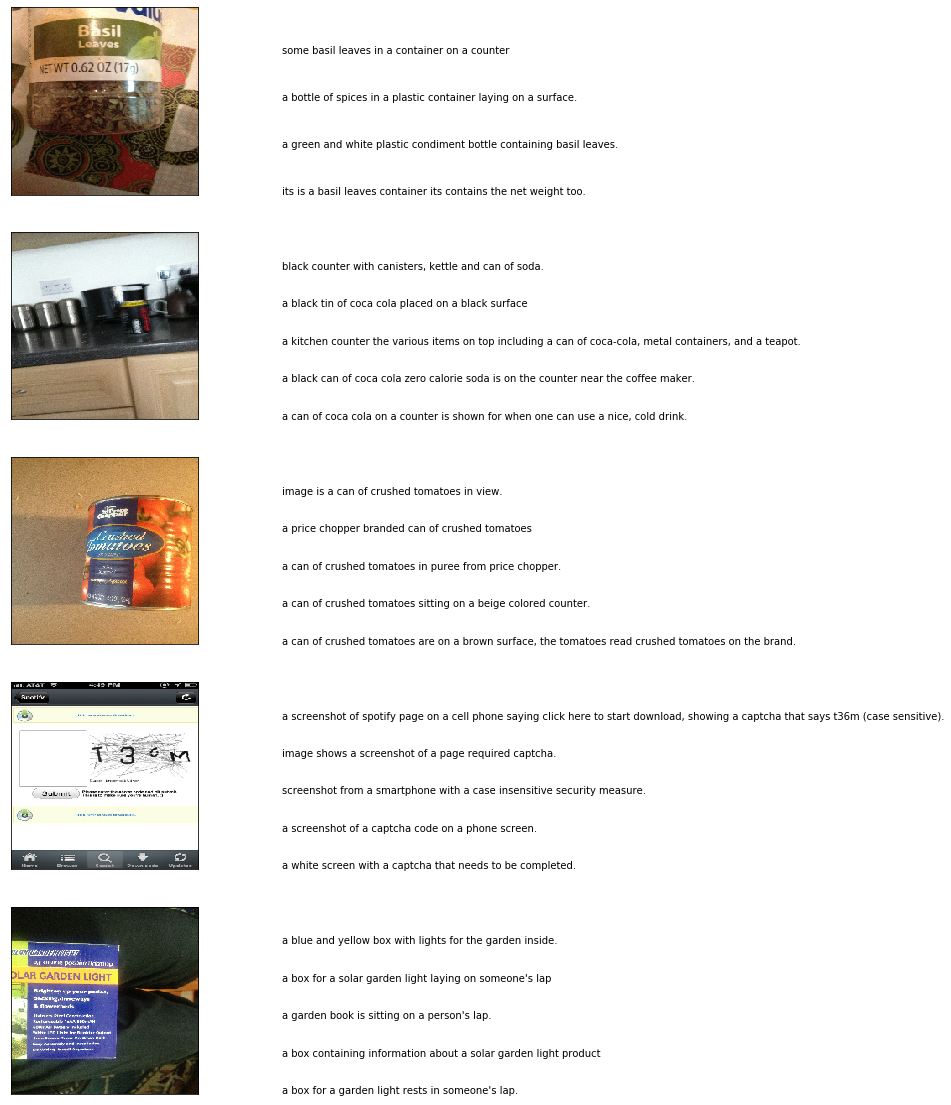

In [105]:
print_sample_images_captions(5, 224, train_unique_filenames, valid_train_pd)

### Sample Validation Images with Captions

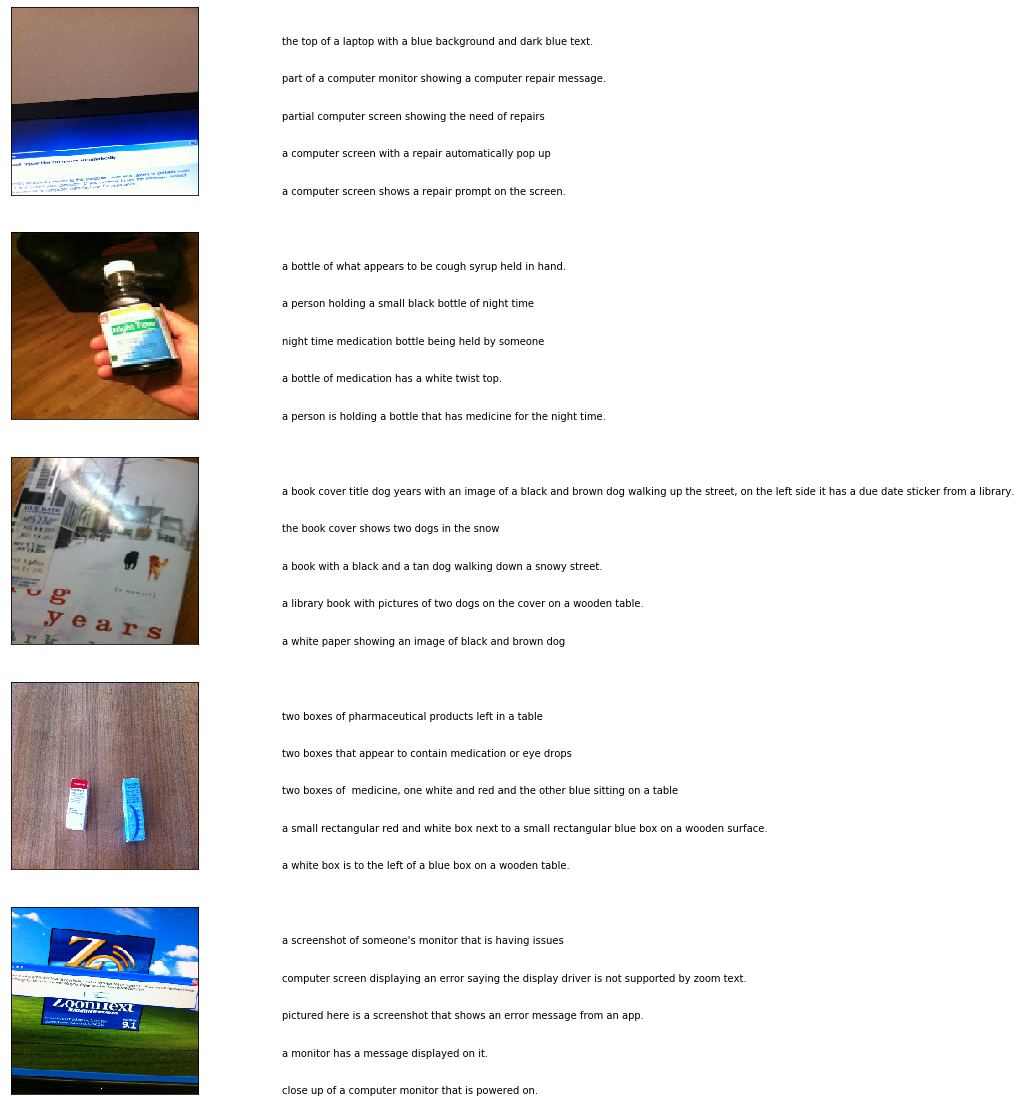

In [106]:
print_sample_images_captions(5, 224, val_unique_filenames, valid_val_pd)

### Sample Test Images

In [16]:
test_unique_filenames = np.unique(test_pd.image_filename.values)
print("The number of unique filenames in Test : {}".format(len(test_unique_filenames)))

The number of unique filenames in Test : 8000


In [17]:
# Display some images with its captions
def print_sample_test_images(n_pics, n_pix, filenames, valid_df):
    #npic = 5
    #npix = 224
    target_size = (n_pix, n_pix, 3)

    count = 1
    fig = plt.figure(figsize=(10, 20))
    for jpgfnm in filenames[:n_pics]:
        filename = jpgfnm
        
        image_load = load_img(filename, target_size = target_size)
        ax = fig.add_subplot(n_pics, 2, count, xticks=[], yticks=[])
        ax.imshow(image_load)
        count += 1
    
        
    plt.show()

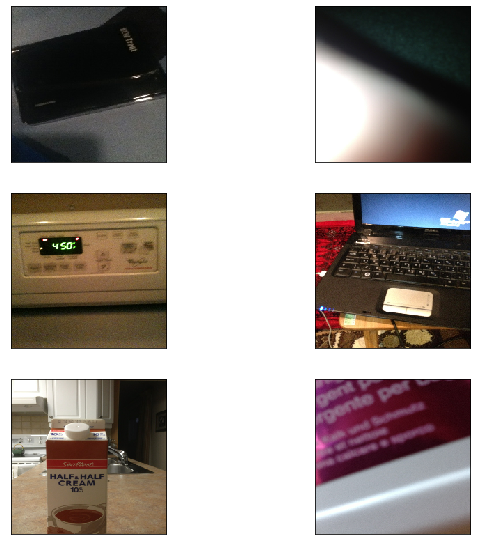

In [18]:
print_sample_test_images(6, 224, test_unique_filenames, test_pd)

### Sample Pre-canned Captions with Images from Train dataset

In [128]:
precanned_train_unique_filenames = np.unique(precanned_train_pd.image_filename.values)
print("The number of unique filenames in Precanned Train : {}".format(len(precanned_train_unique_filenames)))

The number of unique filenames in Precanned Train : 7680


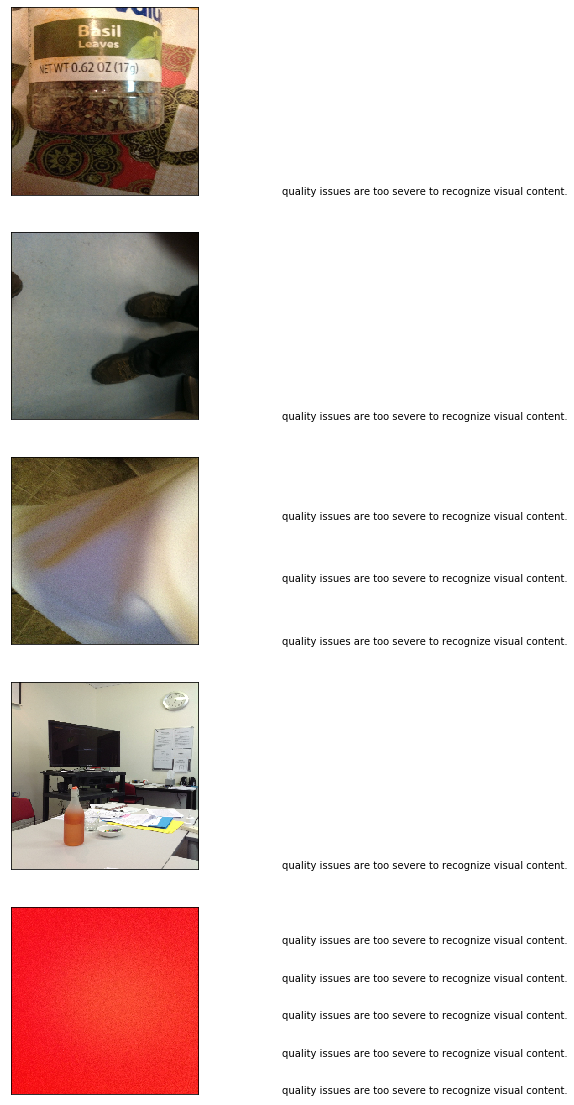

In [129]:
print_sample_images_captions(5, 224, precanned_train_unique_filenames, precanned_train_pd)

### Sample Rejected Captions with Images from Train dataset

In [130]:
rejected_train_unique_filenames = np.unique(rejected_train_pd.image_filename.values)
print("The number of unique filenames in Rejected Train : {}".format(len(rejected_train_unique_filenames)))

The number of unique filenames in Rejected Train : 1395


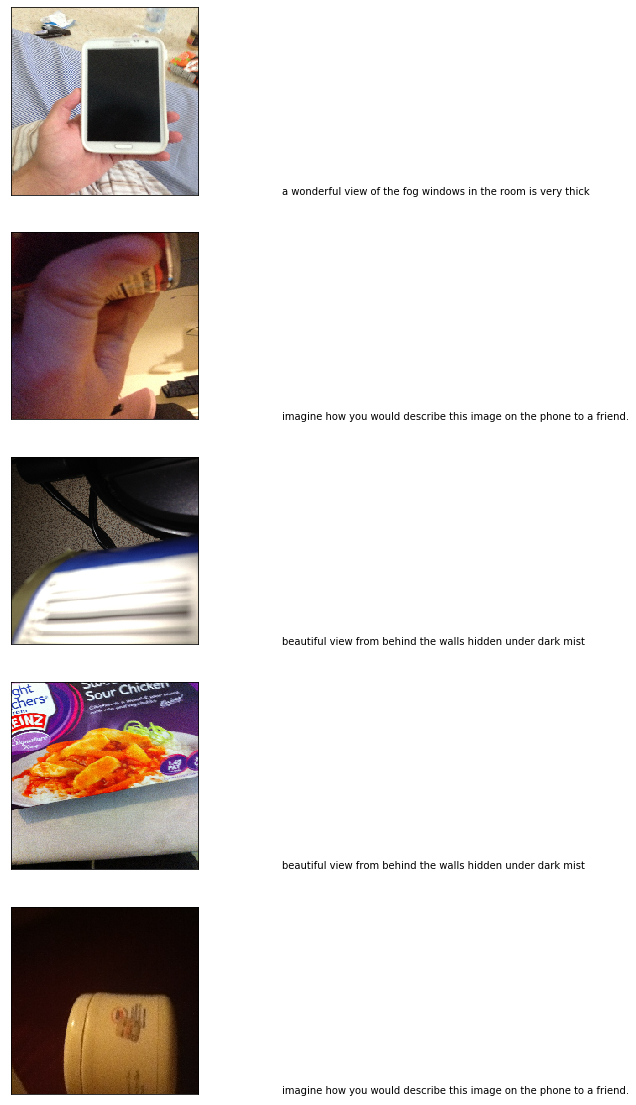

In [131]:
print_sample_images_captions(5, 224, rejected_train_unique_filenames, rejected_train_pd)

### Exploring the captions vocabulary

In [139]:
# Function to show distribution of words in captions
# What is the frequency of occuring of each word in the corpus
def df_word_count(data_info_pd, split):
    vocabulary = []
    for i in range(len(data_info_pd)):
        temp = data_info_pd.iloc[i, 3]
        vocabulary.extend(temp.split())
    print('{} Vocabulary Size: {}'.format(split, len(set(vocabulary))))
    ct = Counter(vocabulary)
    df_word = pd.DataFrame({"word":list(ct.keys()), "count":list(ct.values())})
    df_word = df_word.sort_values("count", ascending=False)
    df_word = df_word.reset_index()[["word", "count"]]
    return(df_word)



In [142]:
df_word_cnt_tr = df_word_count(valid_train_pd, 'train')
df_word_cnt_tr.head(10)

train Vocabulary Size: 29710


,word,count
0,a,152468
1,of,68785
2,on,45275
3,the,36365
4,with,35718
5,and,30846
6,is,23112
7,in,18129
8,white,16455
9,black,10323


In [143]:
df_word_cnt_val = df_word_count(valid_val_pd, 'val')
df_word_cnt_val.head(10)

val Vocabulary Size: 16672


,word,count
0,a,50592
1,of,21217
2,on,14824
3,the,12469
4,with,12140
5,and,10163
6,is,7807
7,in,5753
8,white,5259
9,black,3519


In [145]:
topn = 50

def plt_hist(dfsub, title="The Top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()



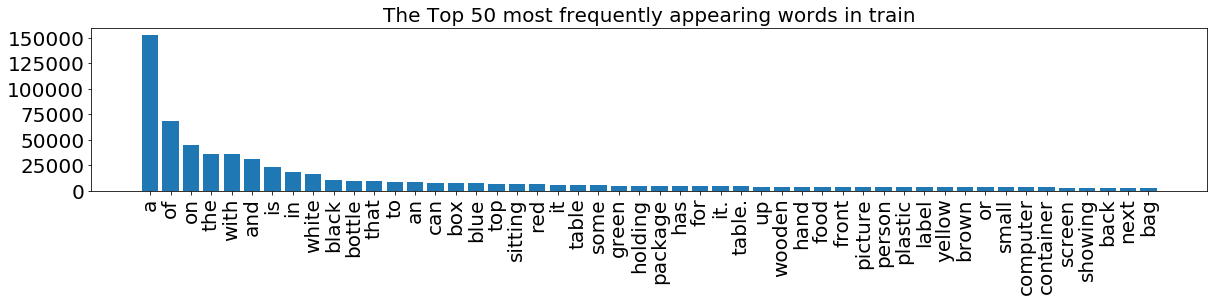

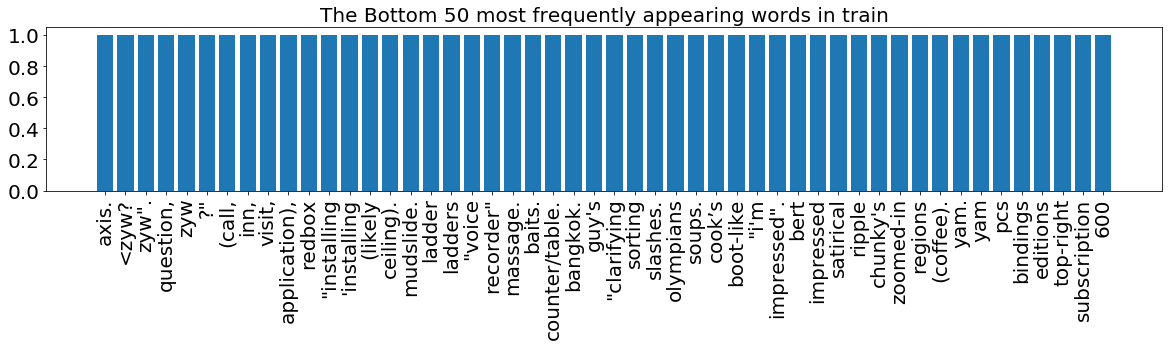

In [146]:
plt_hist(df_word_cnt_tr.iloc[:topn,:],
        title="The Top 50 most frequently appearing words in train")
plt_hist(df_word_cnt_tr.iloc[-topn:,:],
        title="The Bottom 50 most frequently appearing words in train")

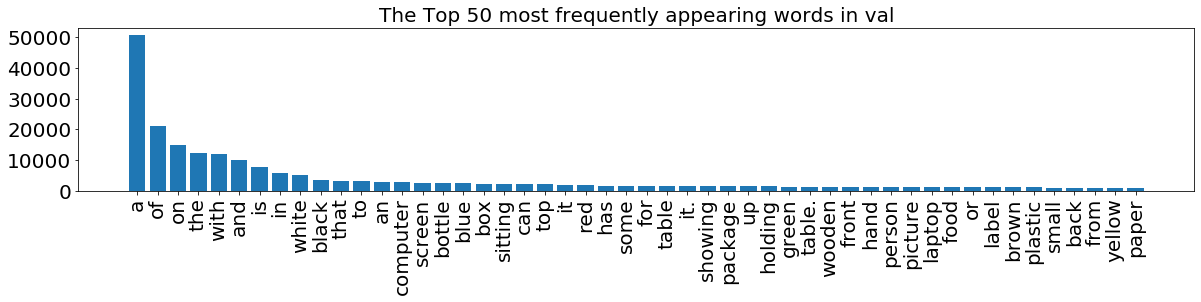

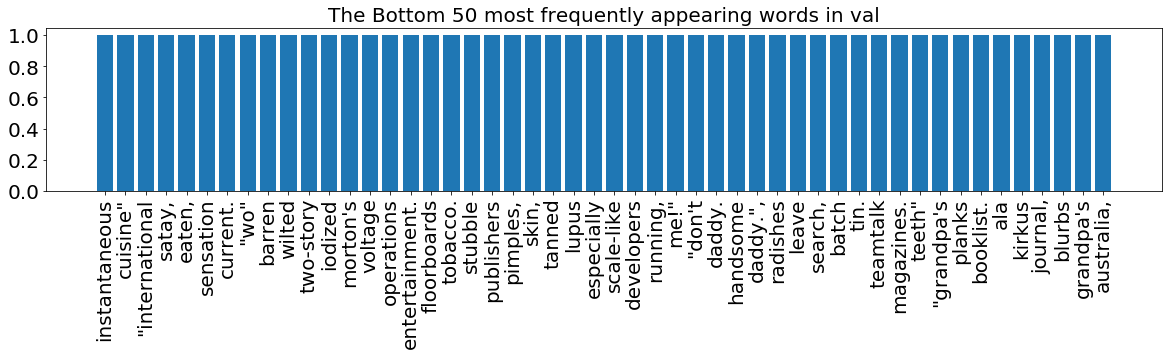

In [148]:
plt_hist(df_word_cnt_val.iloc[:topn,:],
        title="The Top 50 most frequently appearing words in val")
plt_hist(df_word_cnt_val.iloc[-topn:,:],
        title="The Bottom 50 most frequently appearing words in val")